In [152]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
import sklearn.metrics as metrics
from sklearn.tree import DecisionTreeClassifier, plot_tree
%pip install xgboost
import xgboost
from xgboost import XGBClassifier, plot_importance

Note: you may need to restart the kernel to use updated packages.


Dataset Display and Information

In [75]:
pd.set_option("display.max_columns", None)
df = pd.read_csv("cybersecurity_intrusion_data.csv")
df.head()

,session_id,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected
0,SID_00001,599,TCP,4,492.983263,DES,0.606818,1,Edge,0,1
1,SID_00002,472,TCP,3,1557.996461,DES,0.301569,0,Firefox,0,0
2,SID_00003,629,TCP,3,75.044262,DES,0.739164,2,Chrome,0,1
3,SID_00004,804,UDP,4,601.248835,DES,0.123267,0,Unknown,0,1
4,SID_00005,453,TCP,5,532.540888,AES,0.054874,1,Firefox,0,0


In [76]:
#Drop unnecessary columns and check for duplicate rows
df.drop(columns=['session_id'], inplace=True)
df.duplicated().any()

np.False_

Countplot of "sus" and "evil" values in the datset

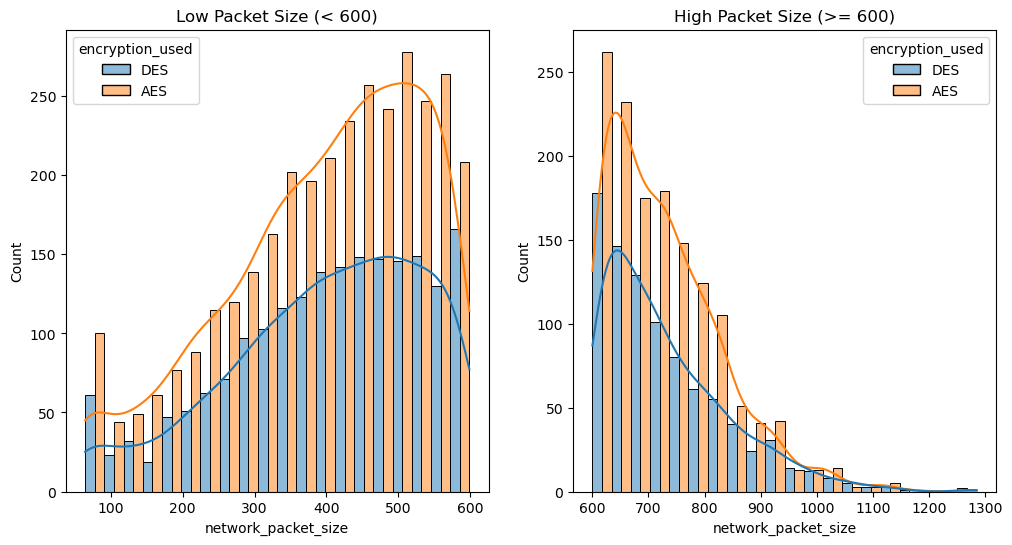

In [77]:
fig, ax = plt.subplots(1, 2, figsize = (12,6))

low_packet_size = df[df["network_packet_size"] < 600]
high_packet_size = df[df["network_packet_size"] >= 600]
sns.histplot(data = low_packet_size, 
             x = "network_packet_size", 
             hue = "encryption_used", 
             bins = 20, kde = True, 
             multiple = "dodge", 
             ax = ax[0])
ax[0].set_title("Low Packet Size (< 600)")
sns.histplot(data = high_packet_size, 
             x = "network_packet_size", 
             hue = "encryption_used", 
             bins = 20, kde = True, 
             multiple = "dodge", 
             ax = ax[1])
ax[1].set_title("High Packet Size (>= 600)")
plt.show()

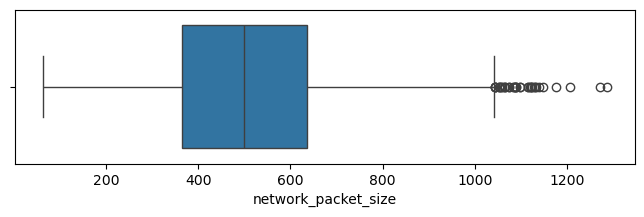

In [78]:
fig, ax = plt.subplots(figsize = (8,2))
sns.boxplot(x="network_packet_size", data=df, vert = False, ax = ax)
plt.show()

In [79]:
#Drop rows with packet size outside of boxplot range
q1 = df["network_packet_size"].quantile(0.25)
q3 = df["network_packet_size"].quantile(0.75)
IQR = q3 - q1
df = df[(df["network_packet_size"] >= (q1 - 1.5 * IQR)) & (df["network_packet_size"] <= (q3 + 1.5 * IQR))]

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9500 entries, 0 to 9536
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   network_packet_size  9500 non-null   int64  
 1   protocol_type        9500 non-null   object 
 2   login_attempts       9500 non-null   int64  
 3   session_duration     9500 non-null   float64
 4   encryption_used      7542 non-null   object 
 5   ip_reputation_score  9500 non-null   float64
 6   failed_logins        9500 non-null   int64  
 7   browser_type         9500 non-null   object 
 8   unusual_time_access  9500 non-null   int64  
 9   attack_detected      9500 non-null   int64  
dtypes: float64(2), int64(5), object(3)
memory usage: 816.4+ KB


In [81]:
#Convert categorical columns to numerical
non_numerical_cols = ["protocol_type", "encryption_used", "browser_type"]
df = pd.get_dummies(df, columns = non_numerical_cols,drop_first=True, dtype = int)

In [82]:
df.head()

,network_packet_size,login_attempts,session_duration,ip_reputation_score,failed_logins,unusual_time_access,attack_detected,protocol_type_TCP,protocol_type_UDP,encryption_used_DES,browser_type_Edge,browser_type_Firefox,browser_type_Safari,browser_type_Unknown
0,599,4,492.983263,0.606818,1,0,1,1,0,1,1,0,0,0
1,472,3,1557.996461,0.301569,0,0,0,1,0,1,0,1,0,0
2,629,3,75.044262,0.739164,2,0,1,1,0,1,0,0,0,0
3,804,4,601.248835,0.123267,0,0,1,0,1,1,0,0,0,1
4,453,5,532.540888,0.054874,1,0,0,1,0,0,0,1,0,0


Create datasets and split into training and testing sets

In [ ]:
X = df.drop(columns = ["attack_detected"])
y = df["attack_detected"]

#Scale features using MinMaxScaler()
X_scaled = MinMaxScaler().fit_transform(X)

#Split data (75% training, 25% testing)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)

In [108]:
def log_metrics(model_name: str, model, y_test_data):
    y_pred = model.predict(X_test)
    table = pd.DataFrame({
        "Model Name" : [model_name],
        "Accuracy": [metrics.accuracy_score(y_test_data, y_pred)],
        "F1 Score": [metrics.f1_score(y_test_data, y_pred)],
        "Precision": [metrics.precision_score(y_test_data, y_pred)],
        "Recall": [metrics.recall_score(y_test_data, y_pred)]
    })
    return table

In [ ]:
rf_params = {
    'max_depth': [None],
    'max_samples': [0.5,0.75,1.0],
    'max_features': [0.7,1.0],
    'min_samples_split': [2,3],
    'min_samples_leaf': [1],
    'n_estimators': [100,300,500]
}
rf_scoring = {'accuracy': 'accuracy', 
              'f1': 'f1', 
              'precision': 'precision', 
              'recall': 'recall'}

In [99]:
rf = RandomForestClassifier(random_state=42)
rf_cv = GridSearchCV(estimator=rf, param_grid=rf_params, scoring=rf_scoring, refit='f1', cv=3, n_jobs=-1, verbose=2)
rf_cv.fit(X_train, y_train)


Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None], 'max_features': [0.7, 1.0],
                         'max_samples': [0.5, 0.75, 1.0],
                         'min_samples_leaf': [1], 'min_samples_split': [2, 3],
                         'n_estimators': [100, 300, 500]},
             refit='f1',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall'},
             verbose=2)

In [110]:
table = log_metrics("Random Forest CV", rf_cv, y_test)
table

,Model Name,Accuracy,F1 Score,Precision,Recall
0,Random Forest CV,0.890105,0.858995,0.996241,0.754986


Display model's metrics of success based on testing set predictions

Classification Report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91      1322
           1       1.00      0.75      0.86      1053

    accuracy                           0.89      2375
   macro avg       0.92      0.88      0.88      2375
weighted avg       0.91      0.89      0.89      2375



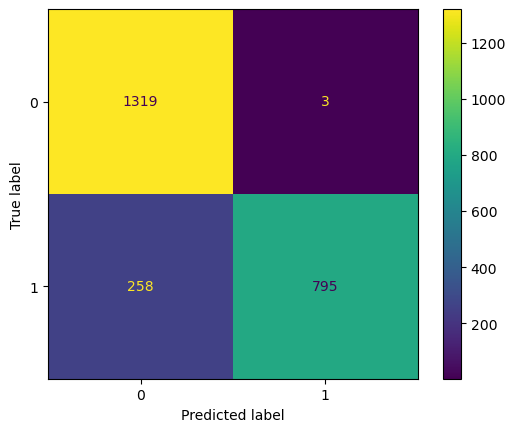

In [111]:
y_pred = rf_cv.predict(X_test)
print(f"Classification Report:\n{metrics.classification_report(y_test, y_pred)}")
disp = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_test, y_pred, labels = rf_cv.classes_), display_labels = rf_cv.classes_)
disp.plot()

In [125]:
tree_params = {
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}
tree_scoring = {
    "accuracy": "accuracy",
    "f1": "f1",
    "roc_auc": "roc_auc"
}

In [126]:
tree = DecisionTreeClassifier(random_state = 42)

tree_cv = GridSearchCV(tree, tree_params, scoring = tree_scoring, cv = 3, refit = "f1", n_jobs = -1, verbose = 2)
tree_cv.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             refit='f1',
             scoring={'accuracy': 'accuracy', 'f1': 'f1', 'roc_auc': 'roc_auc'},
             verbose=2)

In [129]:
table2 = log_metrics("Decision Tree CV", tree_cv, y_test)
table = pd.concat([table, table2], axis = 0)

In [130]:
table

,Model Name,Accuracy,F1 Score,Precision,Recall
0,Random Forest CV,0.890105,0.858995,0.996241,0.754986
0,Decision Tree CV,0.886737,0.855609,0.983951,0.756885


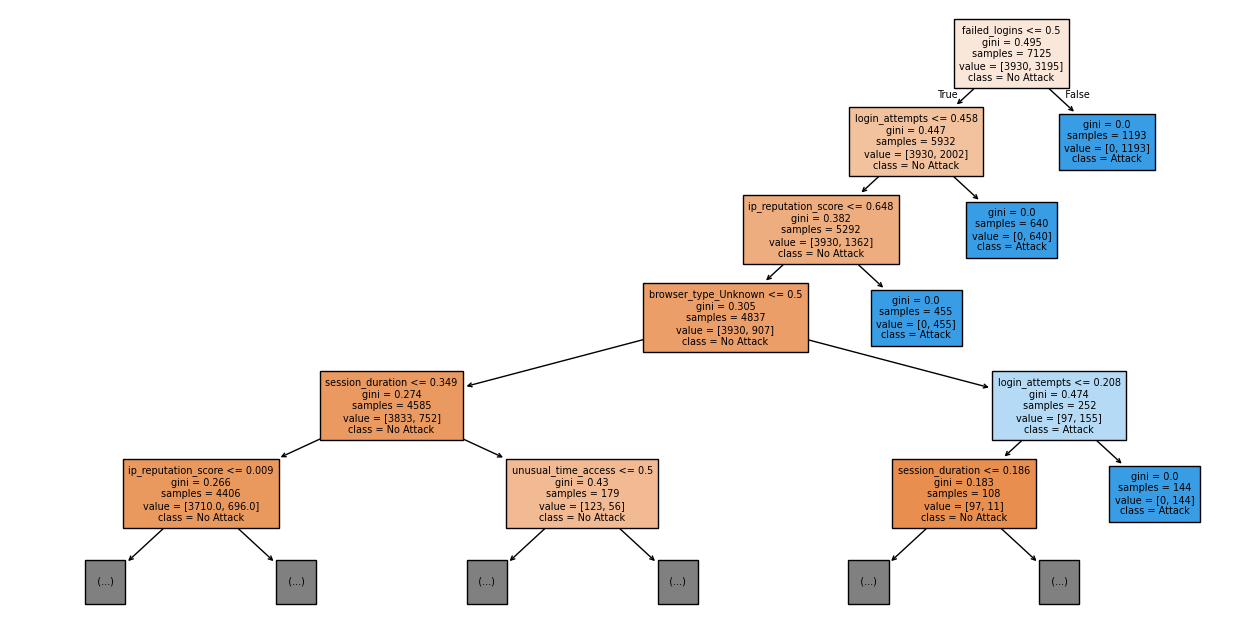

In [ ]:
plt.subplots(figsize = (16,8))
plot_tree(tree_cv.best_estimator_, filled = True, feature_names = X.columns, class_names = ["No Attack", "Attack"], fontsize = 7, max_depth = 5)
plt.show()

In [ ]:
xgb = XGBClassifier(random_state = 42)
xgb_params = {
    "learning_rate": [0.01, 0.1, 0.2],
    'min_child_weight': [1,3,5],
    "max_depth": [3, 5, 7],
    "n_estimators": [100, 300, 500],
    "subsample": [0.7, 1.0]
}
xgb_scoring = {'accuracy': 'accuracy', 
               'f1': 'f1', 
               'precision': 'precision', 
               'recall': 'recall', 
               'roc_auc': 'roc_auc'}

xgb_cv = GridSearchCV(xgb, xgb_params, scoring = xgb_scoring, cv = 3, refit = "f1", n_jobs = -1, verbose = 2)
xgb_cv.fit(X_train, y_train)

Fitting 3 folds for each of 162 candidates, totalling 486 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=Non...
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5],
                         'n_estimators': [100, 300, 500],
                         'subsample': [0.7, 1.0]},
             refit='f1',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'},
             verbose=2)

In [158]:
table3 = log_metrics("XGBoost CV", xgb_cv, y_test)
table = pd.concat([table, table3], axis = 0)
table

,Model Name,Accuracy,F1 Score,Precision,Recall
0,Random Forest CV,0.890105,0.858995,0.996241,0.754986
0,Decision Tree CV,0.886737,0.855609,0.983951,0.756885
0,XGBoost CV,0.890947,0.859773,1.000000,0.754036


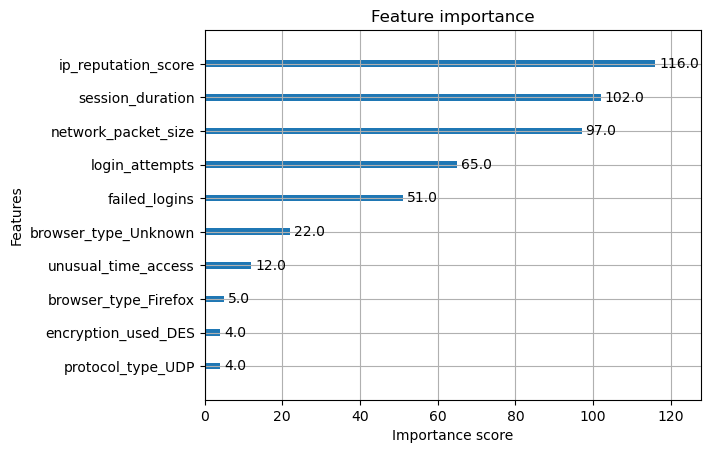

In [169]:
booster = xgb_cv.best_estimator_.get_booster()
booster.feature_names= X.columns.tolist()
plot_importance(booster, importance_type = 'weight',max_num_features=10)
plt.show()